## Identifying Duplicate Questions on Quora
`Ali Bahrami`

January 06, 2022

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a labeled .csv file** and **a presentation that describes the model you built** and its **performance**. 


In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [157]:
df1 = pd.read_csv("data/train.csv")
df1.shape

(404290, 6)

In [163]:
# Too big a dataset, take a sample of 100,000 for time efficiency
df = df1.sample(100000)
# drop rows with missing values
df = df.dropna()
df.shape

(100000, 6)

In [164]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
260035,260035,375907,375908,What is the salary package at testbook.com?,What is the salary package at dasra?,0
391347,391347,216576,523930,Can electricity flow through vacuum?,Does electricity travel through vacuum?,1
276504,276504,395467,395468,How do you simplify (A B) ^2-(ABC)?,How do I find the simplified form of the quoti...,0
286399,286399,316624,406979,How to get my dreaming job?,How do I get my dream job?,0
299064,299064,421654,421655,Why is the Microsoft One Drive so slow (upload)?,I'm unable to search for files and folders on ...,0


### Exploration

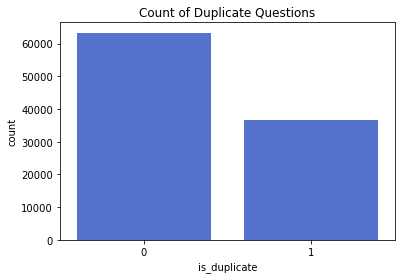

In [165]:
# Check how many questions are duplicate and how many are not
sns.countplot(x=df.is_duplicate, color='royalblue').set(title='Count of Duplicate Questions');

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [166]:
# Import the libraries
import nltk
import string # Removing Punctuation
import re # Tokenization

# Stopwords Cleaning
stopwords = nltk.corpus.stopwords.words('english') 
# Stemming
from nltk.stem import PorterStemmer 
ps = PorterStemmer() 


# Note: we are not using Lemmatization (which is more accurate) because we are more concerned with duplicity and not meaning
# and that Lemmatization is computationally very heavy on such a large dataset

In [7]:
# Define a function to handle all data cleaning
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation]) # Lower case and removing Punctuation
    tokens = re.split('\W+', text) # tokenize: split our sentences into a list of words
    text = [word for word in tokens if word not in stopwords] # remove all stopwords
    text = ' '.join([ps.stem(word) for word in text]) # # stemming
    return text

In [8]:
df['question1'] = df['question1'].apply(clean_text)
df['question2'] = df['question2'].apply(clean_text)

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

### Basic Feature Extraction

In [167]:
df['len_q1'] = df.question1.apply(lambda x: len(str(x)))
df['len_q2'] = df.question2.apply(lambda x: len(str(x)))
df['diff_len'] = df.len_q1 - df.len_q2
df['len_char_q1'] = df.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
df['len_char_q2'] = df.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
df['len_word_q1'] = df.question1.apply(lambda x: len(str(x).split()))
df['len_word_q2'] = df.question2.apply(lambda x: len(str(x).split()))
df['common_words'] = df.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)

In [168]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words
220325,220325,327402,327403,What sensors are used for Sweat Analysis - mor...,How do I build a sensor that detects inactivity?,0,79,48,31,23,20,12,9,0
167202,167202,93002,259264,Who does Yuki end up with in Vampire Knight an...,Why did Ted end up with Robin in HIMYM?,0,52,39,13,21,20,11,9,4
350526,350526,255625,154382,Why do I always feel sleepy?,Why do I feel sleepy everyday?,1,28,30,-2,14,15,6,6,4
49385,49385,87901,87902,What is the best way to ask a favor?,What are the best ways to ask for favors?,1,36,41,-5,16,15,9,9,5
131592,131592,210929,210930,My cousin wants to do a Business and Finance d...,Where can I study math at a university level o...,0,127,52,75,28,19,25,10,2


### Word2Vec Features

In [79]:
import gensim
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True)


In [169]:
## Word Mover's Distance

def norm_wmd(q1, q2):
    q1 = str(q1).lower().split()
    q2 = str(q2).lower().split()
    q1 = [w for w in q1 if w not in stopwords]
    q2 = [w for w in q2 if w not in stopwords]
    return w2v_model.wmdistance(q1, q2)

In [170]:
df['norm_wmd'] = df.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)

In [171]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [172]:
df.shape

(97244, 15)

In [173]:
from nltk import word_tokenize
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stopwords]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(w2v_model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

In [174]:
df.drop(['id', 'qid1', 'qid2', 'question1', 'question2'], axis=1, inplace=True)
df.head()

,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,norm_wmd
234674,0,49,73,-24,21,20,8,12,1,1.313534
17885,1,70,36,34,26,19,14,6,3,1.052830
136274,0,59,55,4,20,23,11,9,7,0.345310
31892,0,39,51,-12,16,17,8,11,7,0.340077
63067,0,55,63,-8,16,19,11,11,4,0.996950


In [175]:
df.dtypes

is_duplicate      int64
len_q1            int64
len_q2            int64
diff_len          int64
len_char_q1       int64
len_char_q2       int64
len_word_q1       int64
len_word_q2       int64
common_words      int64
norm_wmd        float64
dtype: object

### Modeling

Different modeling techniques can be used:

- logistic regression
- Random Forest Classifiers


In [176]:
# Define X and y
y = df['is_duplicate']
X = df.drop(['is_duplicate'], axis=1)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [178]:
pipeline = Pipeline(steps=[('scaling', StandardScaler()),
                           ('kbest', SelectKBest(k=4)),
                           ('classifier', LogisticRegression())])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)


In [179]:
print('Accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy 0.6538603924149562
              precision    recall  f1-score   support

           0       0.70      0.80      0.74     15260
           1       0.55      0.41      0.47      9051

    accuracy                           0.65     24311
   macro avg       0.62      0.60      0.61     24311
weighted avg       0.64      0.65      0.64     24311



/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


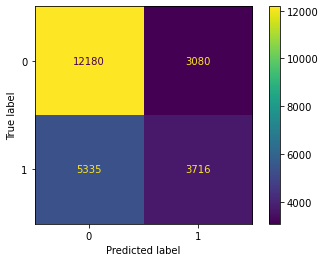

In [180]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_test, y_test)  
plt.show()


In [181]:
pipeline = Pipeline(steps=[('scaling', StandardScaler()),
                           ('kbest', SelectKBest(k=4)),
                           ('classifier', RandomForestClassifier())])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)


In [182]:
print('Accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy 0.6872197770556538
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     15260
           1       0.58      0.58      0.58      9051

    accuracy                           0.69     24311
   macro avg       0.67      0.67      0.67     24311
weighted avg       0.69      0.69      0.69     24311



/Users/foreverrefugee/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


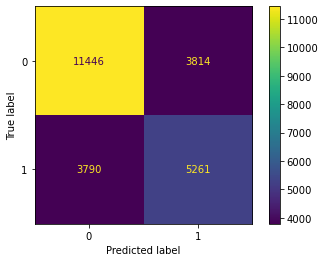

In [183]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_test, y_test)  
plt.show()
